In [ ]:
#NECESARIO
!pip install gdown
!gdown --id 1ceW10j7Puj3DvPTdO1IRLRnRe6KwlEqC #loadmat
!gdown --id 1_ZCBE8y8OqfEYjhdtIwqnSTru-4N_kXQ #pavia.mat
!gdown --id 1X9UWuvApYzBF5ufBGIoMP5Z3rYBARzfP #pavia_gt.mat

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ceW10j7Puj3DvPTdO1IRLRnRe6KwlEqC
From (redirected): https://drive.google.com/uc?id=1ceW10j7Puj3DvPTdO1IRLRnRe6KwlEqC&confirm=t&uuid=cace5043-75c2-41f0-9a40-c6ec945f7ed7
To: /content/loadmat.py
100% 1.24k/1.24k [00:00<00:00, 5.01MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1_ZCBE8y8OqfEYjhdtIwqnSTru-4N_kXQ
From (redirected): https://drive.google.com/uc?id=1_ZCBE8y8OqfEYjhdtIwqnSTru-4N_kXQ&confirm=t&uuid=f0183c89-0452-4390-b578-fd68597cff7a
To: /content/Pavia.mat
100%

In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from tensorflow.keras.layers import concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os.path
from loadmat import loadmat
from IPython.display import display, HTML
import numpy as np
import matplotlib as mpl

# <font color='#4C5FDA'><small>**Cargamos los datos**</small></font>

In [ ]:
data_path = '/content/Pavia.mat'
ground_truth_path = '/content/Pavia_gt.mat'

In [ ]:
#funcion para obtener las llaves de cada .mat
def keys_dataset(data_path, ground_truth_path):
    #cargamos los .mat
    data = loadmat(data_path)
    gt = loadmat(ground_truth_path)

    #retornamos las llaves

    data_keys = data.keys()
    gt_keys = gt.keys()

    return data_keys, gt_keys

# Imprimir las claves (nombres de las variables) del diccionario
keys_dataset(data_path, ground_truth_path)

(dict_keys(['__header__', '__version__', '__globals__', 'pavia']),
 dict_keys(['__header__', '__version__', '__globals__', 'pavia_gt']))

In [ ]:
#desplegando datos

def load_paviau_dataset(data_path, ground_truth_path):

    data = loadmat(data_path)
    gt = loadmat(ground_truth_path)

    # Adjust the keys if they are different in your dataset files.
    img = data['pavia']
    gt = gt['pavia_gt']

    return img, gt

img, gt = load_paviau_dataset(data_path, ground_truth_path)

In [ ]:
#funcion imagen PseudoRGB
def Pavia_rgbandgt (datos_espectrales, imagen_etiquetada):
    # Extraer bandas RGB y apilarlas
    rgb_image = np.dstack([datos_espectrales[:, :, i] for i in [60, 30, 2]])
    rgb_image_norm = ((rgb_image / rgb_image.max()) * 255).astype(np.uint8)
    rgb_image_norm_gamma = (rgb_image_norm ** 1.15).astype(np.uint8) #correccion gamma

    # Configurar los subplots y mostrar las imágenes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(rgb_image_norm_gamma)
    axs[0].set_title('Pavia RGB')
    axs[1].imshow(imagen_etiquetada, cmap='jet')
    axs[1].set_title('Pavia GroundTruth')
    cbar = plt.colorbar(axs[1].imshow(imagen_etiquetada, cmap='jet'), ax=axs[1])
    cbar.set_label('Clases')  # Establecemos el título del colorbar
    plt.show()

    return rgb_image_norm_gamma

In [ ]:
#funcion para las 9 clases
def view_spectralbandspavia(datos_espectrales):
    #coordenadas de cada clase
    coordenadas_clases = {
        'Water': (167, 540), 'Trees': (84, 706), 'Asphalt': (319, 447),
        'Self-Blocking Bricks': (347, 460), 'Bitumen': (297, 487),
        'Tiles': (273, 373), 'Shadows': (617, 659), 'Meadows': (364, 194),
        'Bare Soil': (324, 61),
    }
    #seleccion de los colores de cada clase
    colores = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

    plt.figure(figsize=(12, 6))
    for (clase, coords), color in zip(coordenadas_clases.items(), colores):
        y, x = coords
        plt.plot(datos_espectrales[y, x, :], label=clase, color=color, linewidth=2)

    plt.title('Firmas Espectrales por Clase en Pavia')
    plt.xlabel('Número de Banda')
    plt.ylabel('Reflectancia')
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# <font color='#4C5FDA'><small>**Informacion del dataset**</small></font>

In [ ]:
#informacion de las imagenes
n_r,n_c,n_b = img.shape
print("filas, columnas, bandas")
print(n_r,n_c,n_b)

filas, columnas, bandas
1096 715 102


In [ ]:
# extraemos un pixel

rr,cc = 300, 237
spectrum = img[rr,cc,:]
spectrum

array([706, 558, 325, 249, 153, 110,  91, 107, 112, 118, 130, 125, 110,
        91,  79,  59,  25,  24,  35,  31,  32,  40,  41,  49,  39,  18,
        29,  37,  43,  44,  37,  34,  27,  20,  16,  16,  27,  35,  24,
        14,  11,   3,   6,  23,  32,  28,  26,  18,  17,  23,  17,  17,
        24,  34,  34,  24,  20,  17,  11,  18,  27,  19,  13,  14,  12,
        14,   4,   1,  10,  24,  35,  41,  51,  57,  54,  55,  47,  37,
        42,  46,  47,  46,  66,  91,  93,  68,  51,  62,  60,  46,  61,
        76,  64,  46,  62,  91, 102,  89, 102, 110,  89,  92],
      dtype=uint16)

Text(0, 0.5, 'Reflectancia')

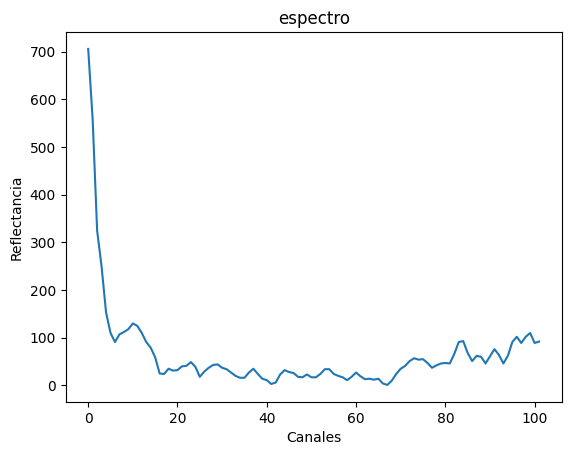

In [ ]:
# trazar un espectro
plt.plot(spectrum)
plt.title('espectro')
plt.xlabel("Canales")
plt.ylabel("Reflectancia")

# <font color='#4C5FDA'><small>**Imagen PseudoRGB V**</small></font>

Text(0.5, 1.0, 'A single band of Hyperspectral Image in False Color')

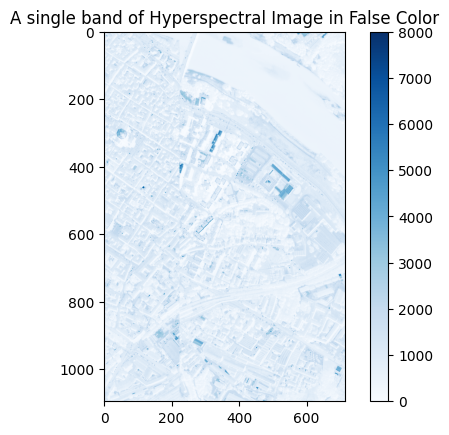

In [ ]:
plt.imshow(img[:,:,30], cmap = 'Blues')
plt.colorbar()
plt.title('A single band of Hyperspectral Image in False Color')

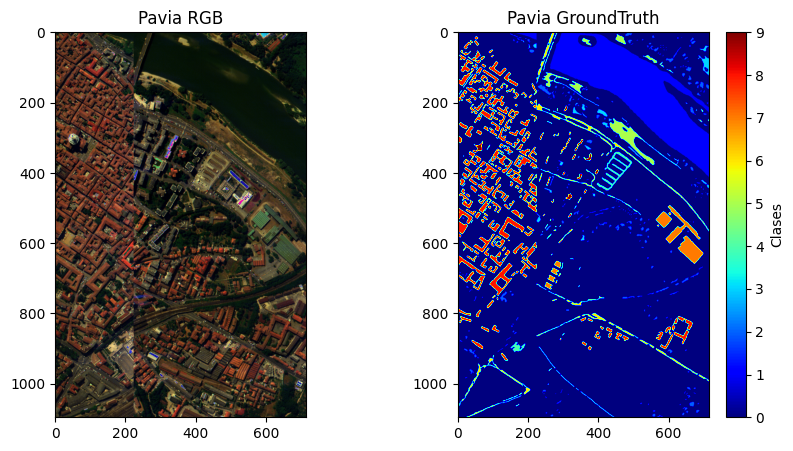

In [ ]:
# Hacer una imagen psuedo-RGB a partir de las bandas adecuadas
rgb_image_norm_gamma = Pavia_rgbandgt(img,gt)

# <font color='#4C5FDA'><small>**Frimas Espectrales**</small></font>

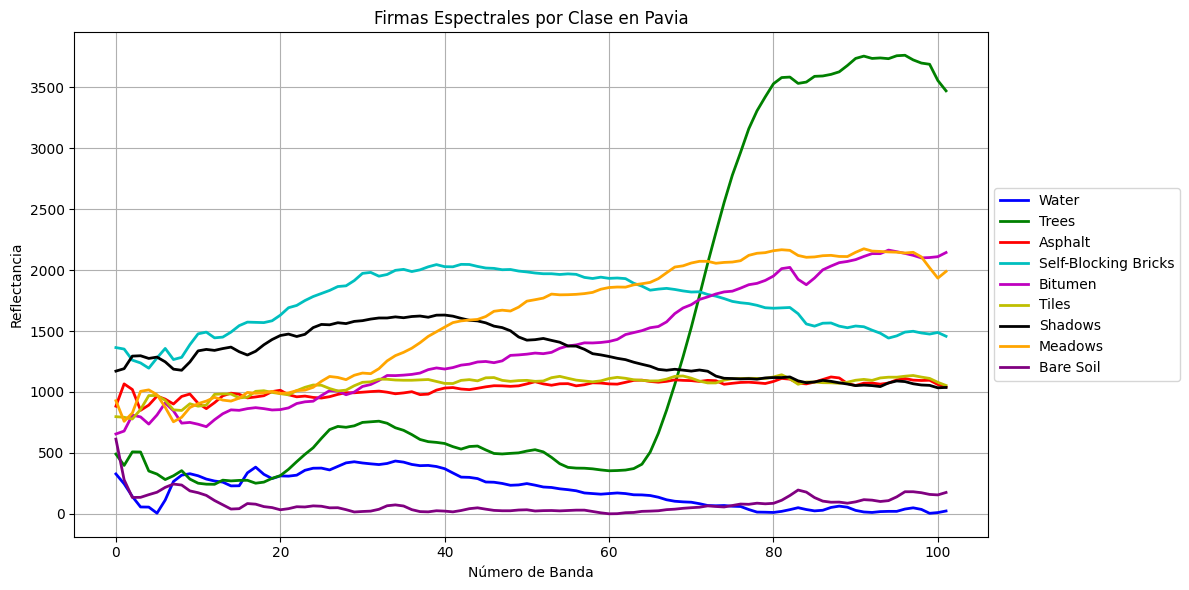

In [ ]:
view_spectralbandspavia(img)

# <font color='#4C5FDA'><small>**Bandas de la imagen PseudoRGB**</small></font>

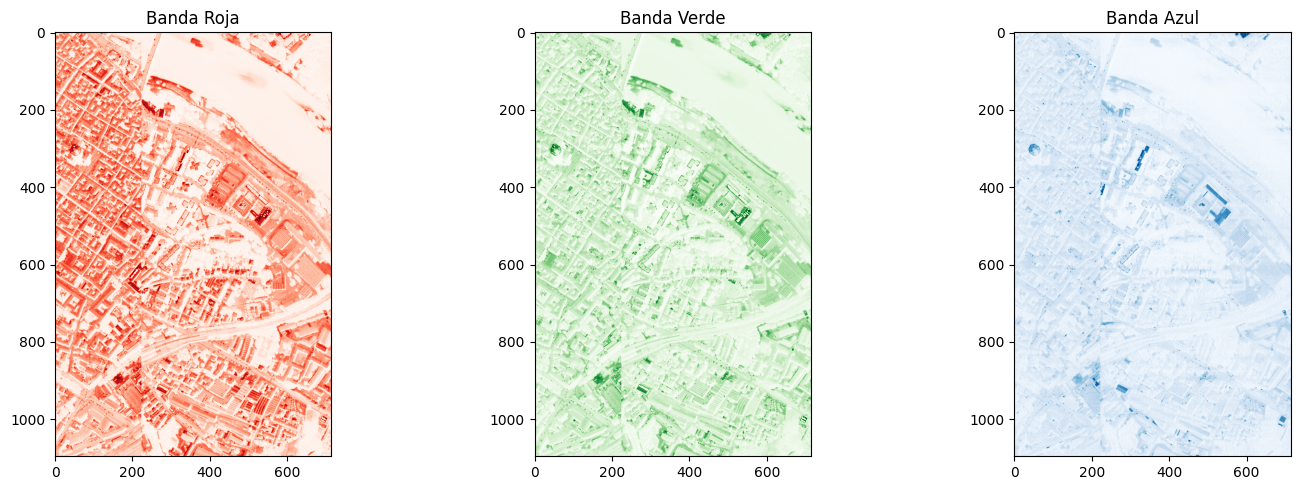

In [ ]:
g, axes = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar la banda roja
axes[0].imshow(rgb_image_norm_gamma[:, :, 0], cmap='Reds')
axes[0].set_title('Banda Roja')

# Mostrar la banda verde
axes[1].imshow(rgb_image_norm_gamma[:, :, 1], cmap='Greens')
axes[1].set_title('Banda Verde')

# Mostrar la banda azul
axes[2].imshow(rgb_image_norm_gamma[:, :, 2], cmap='Blues')
axes[2].set_title('Banda Azul')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

# <font color='#4C5FDA'><small>**imagen PseudoRGB vs imagen Hiperespectral**</small></font>

Text(0.5, 1.0, 'Banda Azul imagen Hiperespectral')

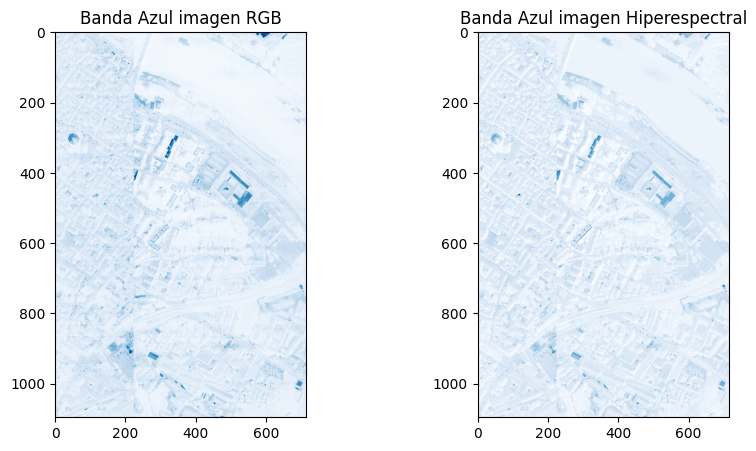

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(rgb_image_norm_gamma[:, :, 2], cmap='Blues')
axes[0].set_title('Banda Azul imagen RGB')

axes[1].imshow(img[:,:,30], cmap='Blues')
axes[1].set_title('Banda Azul imagen Hiperespectral')

# <font color='#4C5FDA'><small>**preprocesamiento  de datos**</small></font>

In [ ]:
#Analisis factorial
def applyFA(X, numComponents=75):
    #Reducimos la dimensionalidad espectral
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

In [ ]:
## Variables Globales
test_ratio = 0.01
windowSize = 12 #necesario que sea un valor pequeño y que concuerde con el modelo

In [ ]:
#division de datos
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
#covertura de ceros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
#creacion de parches
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
img.shape #dimensiones de la Data

(1096, 715, 102)

In [ ]:
gt.shape #dimensiones de las etiquetas

(1096, 715)

In [ ]:
K = img.shape[2]
K #bandas espectrales

102

In [ ]:
K = 3
img,fa = applyFA(img,numComponents=K) #reducimos las bandas espectrales a 3

In [ ]:
img.shape

(1096, 715, 3)

In [ ]:
img, gt = createImageCubes(img, gt, windowSize=windowSize)
img.shape, gt.shape

((148152, 12, 12, 3), (148152,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(img, gt, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((146670, 12, 12, 3), (1482, 12, 12, 3), (146670,), (1482,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1) #optimizacion a la hora de entrenar el modelo
Xtrain.shape

(146670, 12, 12, 3, 1)

In [ ]:
ytrain = to_categorical(ytrain) #etiquetas
ytrain.shape

(146670, 9)

In [ ]:
output_units = 9
S1 = windowSize
L1 = K

# <font color='#4C5FDA'><small>**Entrenamiento del modelo**</small></font>

In [ ]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [ ]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:,0]
    g = batch_image[:,1]
    b = batch_image[:,2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH,
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2,
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3,
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4,
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    # print('shape before')
    # print(transform_batch.shape)
    # print(transform_batch_l2.shape)
    # print(transform_batch_l3.shape)
    # print(transform_batch_l4.shape)

    decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
    decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
    decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
    decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])

    # print('shape after')
    # print(decom_level_1.shape)
    # print(decom_level_2.shape)
    # print(decom_level_3.shape)
    # print(decom_level_4.shape)
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 112, 112, 12]), tuple([None, 56, 56, 12]),
            tuple([None, 28, 28, 12]), tuple([None, 14, 14, 12])]

In [ ]:
img_batch = Kb.zeros(shape=(8, 24, 24, 3), dtype='float32')
Wavelet(img_batch)

[<tf.Tensor: shape=(8, 12, 12, 12), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

In [ ]:
def get_wavelet_cnn_model():

    input_shape =  12, 12, 3

    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # level one decomposition starts
    conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # level two decomposition starts
    conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    # concate level one and level two decomposition
    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)

    conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # level three decomposition starts
    conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    # concate level two and level three decomposition
    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='nomr_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # level four decomposition start
    conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    # concate level level three and level four decomposition
    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

    pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
    #flat_5_1 = Flatten(name='flat_5_1')(pool_5_1)

    #fc_5 = Dense(2048, name='fc_5')(flat_5_1)
    #norm_5 = BatchNormalization(name='norm_5')(fc_5)
    #relu_5 = Activation('relu', name='relu_5')(norm_5)
    #drop_5 = Dropout(0.5, name='drop_5')(relu_5)

    #fc_6 = Dense(2048, name='fc_6')(drop_5)
    #norm_6 = BatchNormalization(name='norm_6')(fc_6)
    #relu_6 = Activation('relu', name='relu_6')(norm_6)
    #drop_6 = Dropout(0.5, name='drop_6')(relu_6)
    flatten_layer = Flatten()(pool_5_1)

    dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
    dense_layer1 = Dropout(0.4)(dense_layer1)
    dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
    dense_layer2 = Dropout(0.4)(dense_layer2)
    output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    plot_model(model, to_file='wavelet_cnn_0.5.png')

    return model

In [ ]:
model = get_wavelet_cnn_model() #visualizacion del modelo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 12, 12, 3)]          0         []                            
                                                                                                  
 wavelet (Lambda)            [(None, 6, 6, 12),           0         ['the_input[0][0]']           
                              (None, 3, 3, 12),                                                   
                              (None, 2, 2, 12),                                                   
                              (None, 1, 1, 12)]                                                   
                                                                                                  
 conv_1 (Conv2D)             (None, 6, 6, 64)             6976      ['wavelet[0][0]']         

In [ ]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
filepath = '/content/best-model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size = 8, validation_data=(Xtest, ytest), epochs=10, callbacks=callbacks_list)

Epoch 1/10
18334/18334 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9510
Epoch 1: saving model to /content/best-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



18334/18334 [==============================] - 291s 15ms/step - loss: 0.1576 - accuracy: 0.9510
Epoch 2/10
18331/18334 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9838
Epoch 2: saving model to /content/best-model.hdf5
18334/18334 [==============================] - 277s 15ms/step - loss: 0.0538 - accuracy: 0.9838
Epoch 3/10
18334/18334 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9912
Epoch 3: saving model to /content/best-model.hdf5
18334/18334 [==============================] - 283s 15ms/step - loss: 0.0306 - accuracy: 0.9912
Epoch 4/10
18333/18334 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9937
Epoch 4: saving model to /content/best-model.hdf5
18334/18334 [==============================] - 273s 15ms/step - loss: 0.0220 - accuracy: 0.9937
Epoch 5/10
18331/18334 [============================>.] - ETA: 0s - loss: 0.0176 - accuracy: 0.9951
Epoch 5: saving model to /content/best-model.hdf5
18334/18334 [===

# <font color='#4C5FDA'><small>**Validacion**</small></font>

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


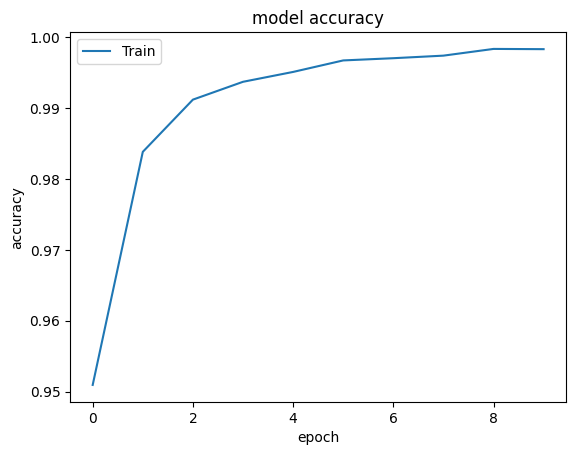

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

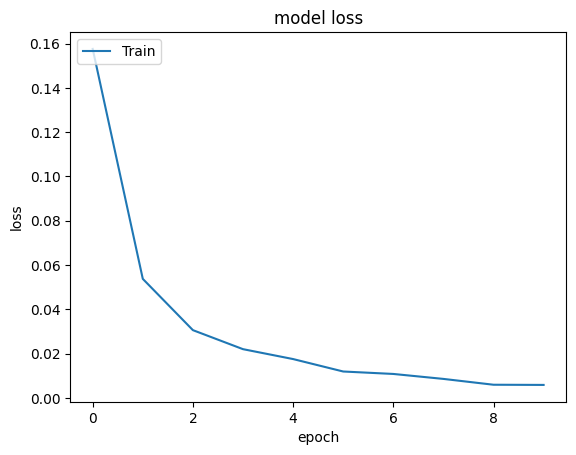

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# load best weights
model.load_weights('/content/best-model.hdf5')
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(1482, 12, 12, 3, 1)

In [ ]:
ytest = to_categorical(ytest)
ytest.shape

(1482, 9)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

47/47 [==============================] - 2s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       660
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        27
           4       1.00      1.00      1.00        66
           5       1.00      1.00      1.00        92
           6       1.00      1.00      1.00        73
           7       1.00      1.00      1.00       428
           8       1.00      1.00      1.00        29

    accuracy                           1.00      1482
   macro avg       1.00      1.00      1.00      1482
weighted avg       1.00      1.00      1.00      1482



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    target_names = ['Water','Asphalt','Trees', 'Self-Blocking Bricks','Bare Soil','Bitumen',
                        'Tiles','Shadows','Meadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)


47/47 [==============================] - 5s 12ms/step - loss: 0.0014 - accuracy: 1.0000


In [ ]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
PATCH_SIZE = 12

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# cargamos la imagen original
X, y = load_paviau_dataset(data_path, ground_truth_path)

In [ ]:
height = y.shape[0]
width = y.shape[1]

In [ ]:
K = 3
X,fa = applyFA(X, numComponents=K)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
#import time

batch_size = 64
output = np.zeros((height, width))
patches = []
positions = []

# Itera sobre la imagen
for i in range(height):
    for j in range(width):
        if j % 10 == 0:
            print(f"fila actual {i}, columna {j}")

        target = int(y[i, j])
        if target == 0:
            continue
        else:
            image_patch = Patch(X, i, j)
            patches.append(image_patch)
            positions.append((i, j))

            # Procesar el lote cuando alcanzamos el tamaño del batch
            if len(patches) == batch_size:
                #start_time = time.time()

                X_test_images = np.array(patches).reshape(batch_size, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
                predictions = model.predict(X_test_images, verbose=0)
                predictions = np.argmax(predictions, axis=1)

                for k, pos in enumerate(positions):
                    output[pos[0], pos[1]] = predictions[k] + 1

                #end_time = time.time()
                #print(f"Time for batch prediction: {end_time - start_time} seconds")

                # Resetear listas de patches y posiciones
                patches = []
                positions = []

# Procesar los patches restantes si hay
if patches:
    X_test_images = np.array(patches).reshape(len(patches), image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
    predictions = model.predict(X_test_images, verbose=0)
    predictions = np.argmax(predictions, axis=1)

    for k, pos in enumerate(positions):
        output[pos[0], pos[1]] = predictions[k] + 1


Streaming output truncated to the last 5000 lines.
fila actual 1026, columna 400
fila actual 1026, columna 410
fila actual 1026, columna 420
fila actual 1026, columna 430
fila actual 1026, columna 440
fila actual 1026, columna 450
fila actual 1026, columna 460
fila actual 1026, columna 470
fila actual 1026, columna 480
fila actual 1026, columna 490
fila actual 1026, columna 500
fila actual 1026, columna 510
fila actual 1026, columna 520
fila actual 1026, columna 530
fila actual 1026, columna 540
fila actual 1026, columna 550
fila actual 1026, columna 560
fila actual 1026, columna 570
fila actual 1026, columna 580
fila actual 1026, columna 590
fila actual 1026, columna 600
fila actual 1026, columna 610
fila actual 1026, columna 620
fila actual 1026, columna 630
fila actual 1026, columna 640
fila actual 1026, columna 650
fila actual 1026, columna 660
fila actual 1026, columna 670
fila actual 1026, columna 680
fila actual 1026, columna 690
fila actual 1026, columna 700
fila actual 1026, c

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



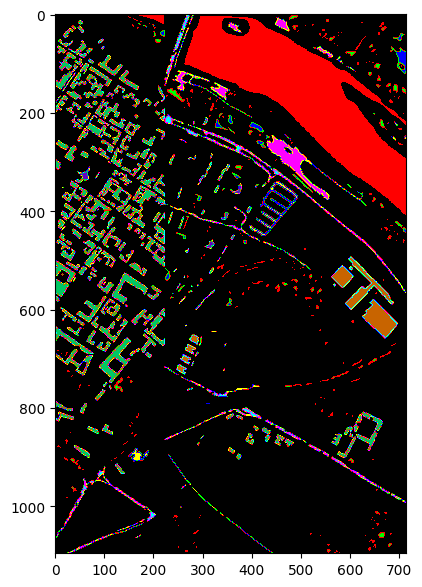

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

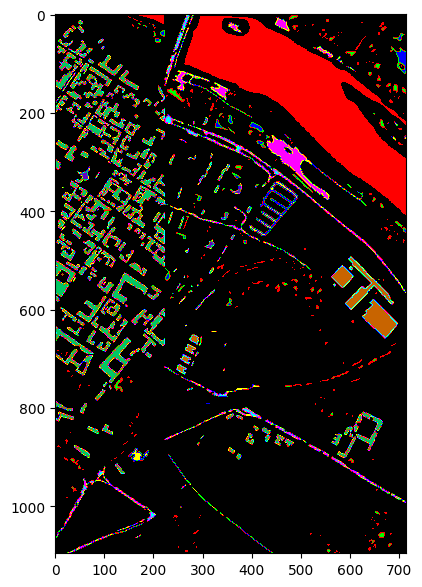

In [ ]:
predict_image_1 = spectral.imshow(classes = output.astype(int),figsize =(7,7))